# Analysis of Micron Stock 
##### 9/28/2020

Micron Technology is a semiconductor company that specializes in computer memory and computer data storage. Microns business divisions are primarily comprised of 2 components, Core DRAM & NAND flash. Core DRAM represents 60.7% of Microns market cap and NAND flash represents for 36% of market cap. Tomorrow, September 29th Micron reports Q4 earnings and they are expected to be relatively bullish.

*Disclaimer: I purchased 50/55 bull call spread on Micron stock, so I anticipate Micron to beat expectations and see a positive EPS suprise.*

#### Import required packages

In [1]:
import yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import talib

import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#### Import data

In [44]:
n_forward = 40
name = 'MU'
start_date = "2015-09-28"
end_date = "2020-09-28"

In [45]:
ticker = yfinance.Ticker(name)
data = ticker.history(interval="1d",start=start_date,end=end_date)
data.tail(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-09-21,49.61,49.78,47.89,49.15,21257500,0,0
2020-09-22,49.27,49.78,48.78,49.70,10845300,0,0
2020-09-23,51.01,51.61,49.64,49.85,19160000,0,0
2020-09-24,49.52,50.36,49.09,49.47,13842300,0,0
2020-09-25,49.57,49.60,47.78,49.14,17760300,0,0


#### Moving Averages 

The most commonly used Moving Averages (MAs) for analyses are the simple and exponential moving average. Simple Moving Average (SMA) takes the average over some set number of time periods. The calculation for the SMA is simply the sum of the stock's closing prices during a time period, divided by the number of observations for that period. The Exponential Moving Average (EMA) assigns a higher weight to recent prices, while the SMA assigns equal weight to all values. We will be using both the SMA and EMA for this analysis.

#### MIcron daily closing price (2016 - present)

In [46]:
#Graph Formatting
plt.rcParams['figure.figsize'] = [10, 7]
plt.rc('font', size=14)

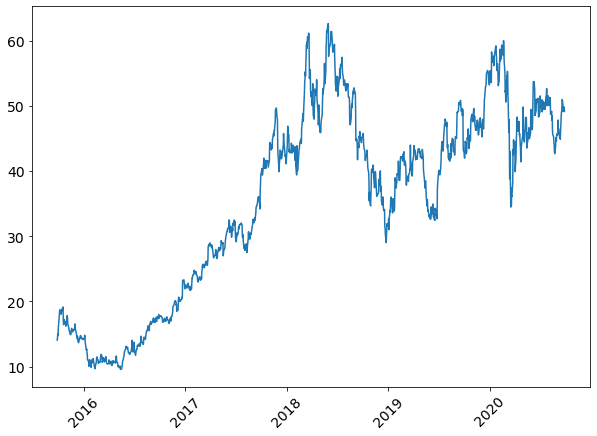

In [47]:
plt.plot(data['Close'],label='Micron Technology')
plt.xticks(rotation=45)
plt.show();

#### Graph the 20, 50, and 200 day Simple Moving Averages (SMA)

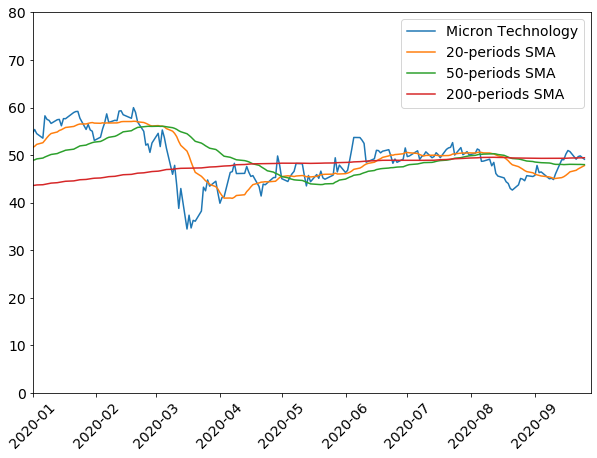

In [48]:
plt.plot(data['Close'],label='Micron Technology')

plt.plot(data['Close'].rolling(20).mean(),label = "20-periods SMA")
plt.plot(data['Close'].rolling(50).mean(),label = "50-periods SMA")
plt.plot(data['Close'].rolling(200).mean(),label = "200-periods SMA")
   
plt.legend()
plt.xlim((datetime.date(2020,1,1),datetime.date(2020,9,28)))
plt.ylim((0,80))
plt.xticks(rotation=45)
plt.show();

In September, Micron stock price did well by "gapping up" over the 50-day average and is now trading at the 200 SMA. We can see the 20 & 50 day SMA act as support levels, in hopes the stock price will move above the 200 day SMA.

#### Find the optimal simple moving average 

*Note: You must choose a start date with 3+ years to have enough data observation to find the optimal SMA*

In [49]:
ticker = yfinance.Ticker(name)
data = ticker.history(interval="1d",start=start_date,end=end_date)

data['Forward Close'] = data['Close'].shift(-n_forward)
data['Forward Return'] = (data['Forward Close'] - data['Close'])/data['Close']

In [50]:
result = []
train_size = 0.6

for sma_length in range(20,500):
  
  data['SMA'] = data['Close'].rolling(sma_length).mean()
  data['input'] = [int(x) for x in data['Close'] > data['SMA']]
  
  df = data.dropna()

  training = df.head(int(train_size * df.shape[0]))
  test = df.tail(int((1 - train_size) * df.shape[0]))
  
  tr_returns = training[training['input'] == 1]['Forward Return']
  test_returns = test[test['input'] == 1]['Forward Return']

  mean_forward_return_training = tr_returns.mean()
  mean_forward_return_test = test_returns.mean()

  pvalue = ttest_ind(tr_returns,test_returns,equal_var=False)[1]
 
  result.append({
      'sma_length':sma_length,
      'training_forward_return': mean_forward_return_training,
      'test_forward_return': mean_forward_return_test,
      'p-value':pvalue
  })

If the P-value is less than .05 we can reject the null hypothesis. Since the P-value is less than .05 (p-value = 5.49681116294302e-32), we can rely on our optimization function by rejecting the null. 

In [51]:
result.sort(key = lambda x : -x['training_forward_return'])
result[0]

{'sma_length': 93,
 'training_forward_return': 0.11033218948938882,
 'test_forward_return': -0.02094338611625163,
 'p-value': 5.49681116294302e-32}

In [52]:
best_sma = result[0]['sma_length']
data['SMA'] = data['Close'].rolling(best_sma).mean()

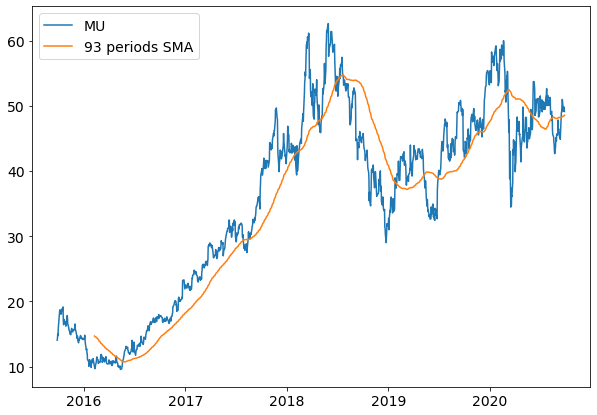

In [53]:
plt.plot(data['Close'],label=name)
plt.plot(data['SMA'],label = "{} periods SMA".format(best_sma))

plt.legend()
plt.show()

The optimal time period for the SMA is 93.

## MACD crossover

In [78]:
# Change the dates for MACD

name = 'MU'
start_date = "2020-01-28"
end_date = "2020-09-28"

ticker = yfinance.Ticker(name)
data = ticker.history(interval="1d",start=start_date,end=end_date)

#### Calculate the Short Term (12 day) Exponential Moving Average - *Fast moving average*

In [79]:
ShortEMA = data.Close.ewm(span=12, adjust=False).mean()

#### Calculate the Long Term (26 day) Exponential Moving Average - *Slow moving average*

In [80]:
LongEMA = data.Close.ewm(span=26, adjust=False).mean() #AKA Slow moving average

#### Calculate the Moving Average Convergence/Divergence (MACD)

In [81]:
MACD = ShortEMA - LongEMA

#### Calculate the signal line

In [82]:
signal = MACD.ewm(span=9, adjust=False).mean()

### Plot the MACD

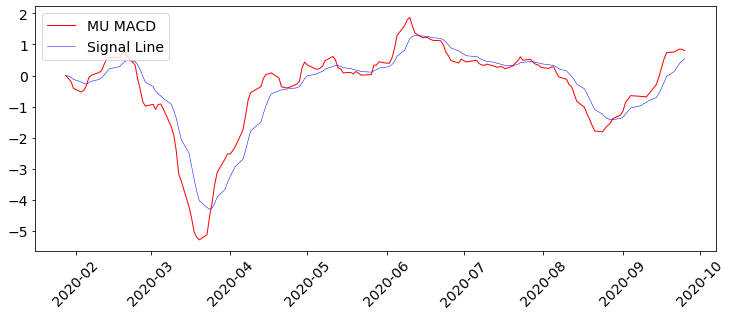

In [83]:
#Plot the chart
plt.figure(figsize=(12.2,4.5)) #width = 12.2in, height = 4.5
plt.plot(data.index, MACD, label='MU MACD', color = 'red', linewidth=1)
plt.plot(data.index, signal, label='Signal Line', color='blue', linewidth=.5)
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()

On September 9th, the MACD indicator crossed over the signal line from underneath, which is considered a bullish crossover

### Now lets plot the Relative Strength Indicator (RSI)

In [86]:
rsi = talib.RSI(data["Close"])

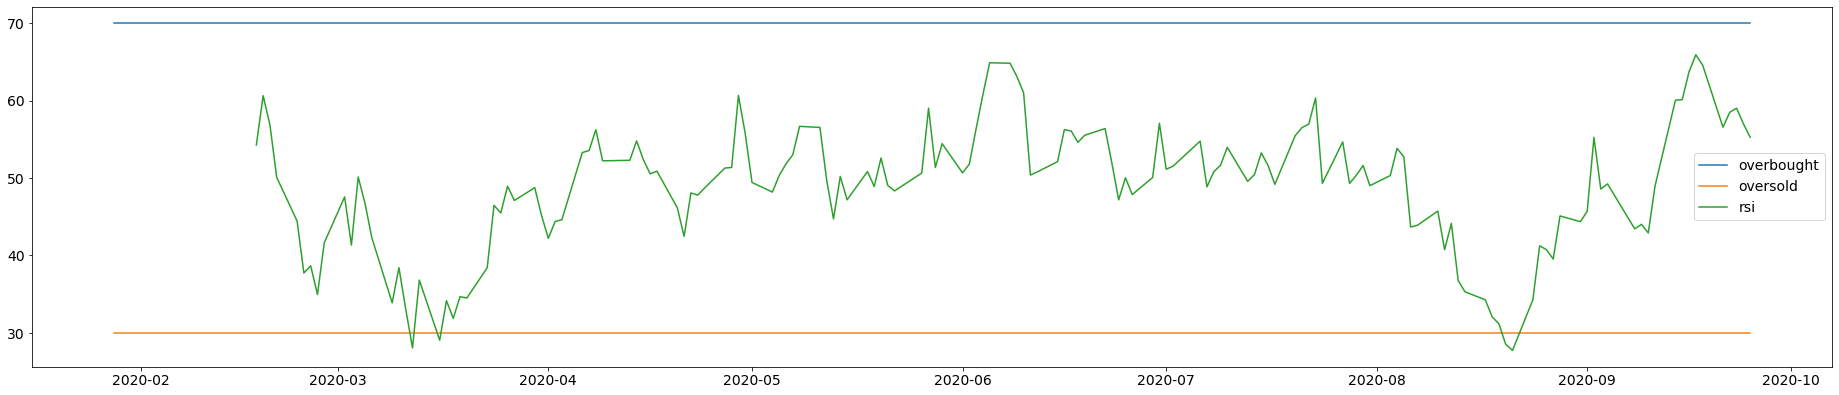

<Figure size 720x504 with 0 Axes>

In [91]:
fig = plt.figure()
fig.set_size_inches((25, 25))
ax_rsi = fig.add_axes((0, 0.24, 1, 0.2))
ax_rsi.plot(data.index, [70] * len(data.index), label="overbought")
ax_rsi.plot(data.index, [30] * len(data.index), label="oversold")
ax_rsi.plot(data.index, rsi, label="rsi")
#ax_rsi.plot(data["Close"])
ax_rsi.legend();
fig = plt.figure();


RSI is around 50 which doesn't provide much valuable information. A bullish investor would argue that the RSI is at its average, and we should expect to see momentun soon.